# Auxiliary telescope simulation with Poppy
==============================================================

- author : Sylvie Dagoret-Campagne
- affiliation : LAL/CNRS
- date March 20th 2017



We want to study the spectrometry in a telescope.
The spectrometer consist in a telescope, with a converging beam.
Inside the converging beam, a grating in transmission is installed to induce dispersion.
The grating could be implemented in two options:
- a Ronchi grating option (exemple 200 lines /mm)
- an Hologram Optical element (HOE) (that we have designed to mimic the Ronchi 200 lines/mm).

We want to implement the two grating elements in poppy.

We want to check on the CCD plane the diffraction effect at warious wavelenght and compare the wavelength resolution between the two options.
Notice the CCD plane is really perpendicular to the optical axis.
The CCD plane is not slanted (because the telescope may do imaging when the grating is removed).


## The Fresnel case
-------------------------



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib as mpl
import pandas as pd
import itertools

In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [3]:
import poppy
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'large'
poppy.__version__

Populating the interactive namespace from numpy and matplotlib


u'0.5.1'

In [4]:
from poppy.poppy_core import PlaneType
import astropy.units as u
import astropy.io.fits as fits

In [5]:
import logging
logging.getLogger('poppy').setLevel(logging.WARN)  
#Can be logging.CRITICAL, logging.WARN, logging.INFO, logging.DEBUG for increasingly verbose output

## Constants

In [6]:
arcmin_to_arcsec=60
deg_arcmin=60.
deg_to_rad=np.pi/180.
rad_to_deg=1./deg_to_rad
rad_to_arcmin=rad_to_deg*deg_arcmin
rad_to_arcsec=rad_to_deg*deg_arcmin*arcmin_to_arcsec

In [7]:
print rad_to_arcsec

206264.806247


## Parameters of telescope at CTIO 0.9 m


- before having the Calypso telescope, we perform some test at CTIO telescope.


In [8]:
telescope_ctio_diameter=0.9 # meter
ccd_ctio_fov=13.6*arcmin_to_arcsec # arcsec
Npixel_ctio=2048
pixel_fov=ccd_ctio_fov/Npixel_ctio # arcsec

In [9]:
wavelength_0=600e-9 # in meter

In [10]:
fl_pri = 12.6 * u.m  # Main Focal length

In [11]:
ronchi_distance_to_focus=0.0576*u.m

## 1) Implementation of CTIO optics without grating 
---------------------------------------------------------------

- This implementation is inspired from Poppy Hubble Telescope:

http://nbviewer.jupyter.org/github/mperrin/poppy/blob/master/notebooks/Fresnel_Propagation_Demo.ipynb


In [12]:
ctio = poppy.FresnelOpticalSystem(pupil_diameter=telescope_ctio_diameter*u.m, npix=1024, beam_ratio=0.25)
m = poppy.QuadraticLens(fl_pri, name='Mirror')
ctio.add_optic(poppy.CircularAperture(radius=telescope_ctio_diameter/2.))
ctio.add_optic(m)
ctio.add_optic(poppy.ScalarTransmission(planetype=PlaneType.image, name='focus'), distance=fl_pri);

In [13]:
ctio.describe()

	Entrance pupil diam:  0.9 m	npix: 1024	Beam ratio:0.25
	Optic: Circle, radius=0.45 m
	Lens: Mirror, with focal length 12.6 m
	Propagation distance:  12.6 m
	Image plane: focus (Analytic)


###  A) Fresnel diffraction pattern 
-----------------------------------

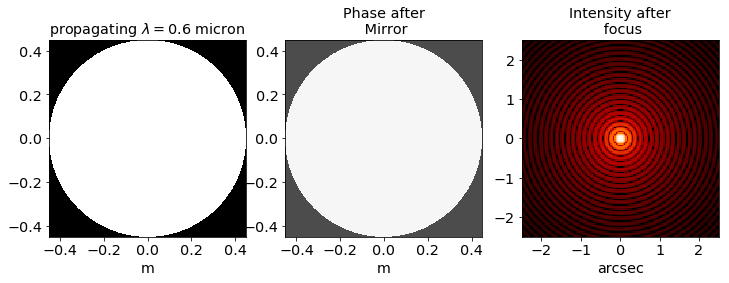

In [14]:
plt.figure(figsize=(12,8))
psf, waves = ctio.calcPSF(wavelength=wavelength_0, display_intermediates=True, return_intermediates=True)

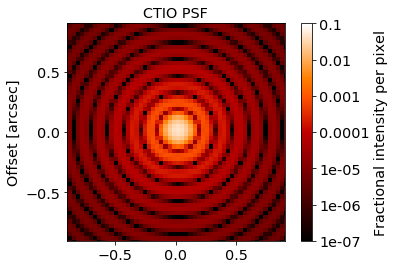

In [15]:
poppy.display_PSF(psf,imagecrop=1.8)
plt.title('CTIO PSF')
plt.ylabel("Offset [arcsec]");

In [16]:
ctio_profile=poppy.utils.radial_profile(psf)

## B) Fraunhofer  diffraction pattern of the same aperture
--------------------------------------------------------------------

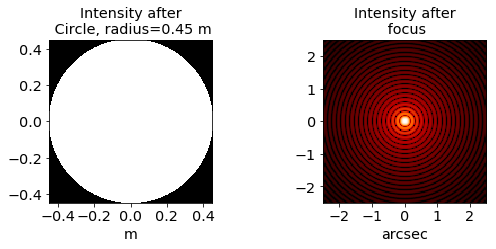

In [17]:
ctio_fraunhofer = poppy.OpticalSystem(pupil_diameter=telescope_ctio_diameter*u.m, npix=1024,oversample=4)
ctio_fraunhofer.addPupil(poppy.CircularAperture(radius=telescope_ctio_diameter/2))
ctio_fraunhofer.addImage(poppy.ScalarTransmission(planetype=PlaneType.image, name='focus'));
plt.figure(figsize=[9,3])
fraunhofer_psf = ctio_fraunhofer.calcPSF(wavelength=wavelength_0, display_intermediates=True, return_intermediates=False)

In [18]:
fraunhofer_profile=poppy.utils.radial_profile(fraunhofer_psf)

###  C) Airy disk calculation
-----------------------------

airy shape =  (128, 128)
2048


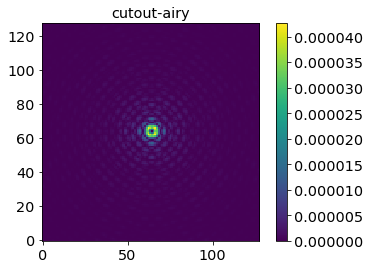

In [19]:
airy=poppy.misc.airy_2d(diameter=telescope_ctio_diameter, wavelength=wavelength_0,
                              shape=(128,128), pixelscale=psf[0].header['PIXELSCL'],
                             center=(64,64))
print 'airy shape = ',airy.shape
airy_fits=fits.HDUList([fits.PrimaryHDU(airy)])
airy_fits[0].header['PIXELSCL'] = psf[0].header['PIXELSCL']
airy_profile=poppy.utils.radial_profile(airy_fits)


centerpix = int(ctio.npix / ctio.beam_ratio / 2)
print centerpix
cutout = psf[0].data[centerpix-64:centerpix+64, centerpix-64:centerpix+64] / psf[0].data[centerpix,centerpix]

#plt.subplot(121)
plt.imshow(np.abs(cutout-airy) )
plt.colorbar()
plt.title("cutout-airy")

#assert( np.abs(cutout-airy).max() < 1e-4 )

In [20]:
#calculate radial profiles
rayleigh_criterion=1.22*wavelength_0/telescope_ctio_diameter*rad_to_arcsec

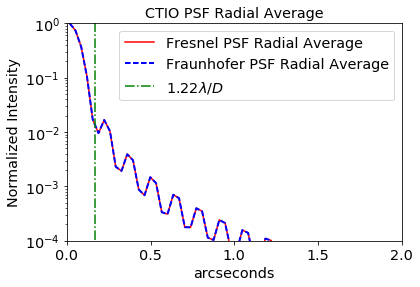

In [21]:
plt.figure()
plt.xlim(0.,2.)
plt.plot(ctio_profile[0],ctio_profile[1]/ctio_profile[1].max(),"r-",label="Fresnel PSF Radial Average")
plt.plot(fraunhofer_profile[0],fraunhofer_profile[1]/fraunhofer_profile[1].max(),"b--",
         linewidth=2,label="Fraunhofer PSF Radial Average")
plt.plot([rayleigh_criterion,rayleigh_criterion],[0e-4,1],'g-.',label="$1.22\lambda/D$")

plt.yscale("log")
plt.xlim([0,2.])
plt.ylim([1e-4,1])
plt.ylabel("Normalized Intensity")
plt.xlabel("arcseconds")
plt.title("CTIO PSF Radial Average")
plt.legend()

## 2) Implementation of CTIO optics with grating 

In [22]:
ctio_grat = poppy.FresnelOpticalSystem(pupil_diameter=telescope_ctio_diameter*u.m, npix=1024, beam_ratio=0.25)
mg = poppy.QuadraticLens(fl_pri, name='Mirror')
ctio_grat.add_optic(poppy.CircularAperture(radius=telescope_ctio_diameter/2.))
ctio_grat.add_optic(mg)

### add grating

In [23]:
ronchi = poppy.FITSOpticalElement(transmission='trans_ronchi200.fits', opd='opd_ronchi200.fits')

(<matplotlib.axes._subplots.AxesSubplot at 0x13216b510>,
 <matplotlib.axes._subplots.AxesSubplot at 0x131fee410>)

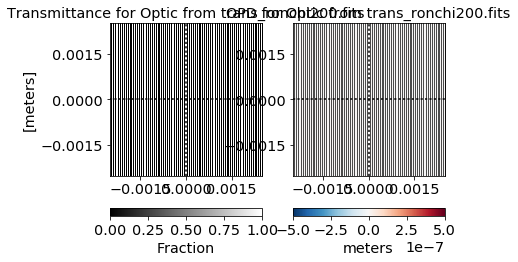

In [24]:
ronchi.display(what='both')    

In [25]:
ctio_grat.add_optic(ronchi, distance=(fl_pri - ronchi_distance_to_focus))

In [26]:
ctio_grat.add_optic(poppy.ScalarTransmission(planetype=PlaneType.image, name='focus'), distance=fl_pri);

In [27]:
ctio_grat.describe()

	Entrance pupil diam:  0.9 m	npix: 1024	Beam ratio:0.25
	Optic: Circle, radius=0.45 m
	Lens: Mirror, with focal length 12.6 m
	Propagation distance:  12.5424 m
	Pupil plane: Optic from trans_ronchi200.fits 
	Propagation distance:  12.6 m
	Image plane: focus (Analytic)


No handlers could be found for logger "poppy"


TypeError: slice indices must be integers or None or have an __index__ method

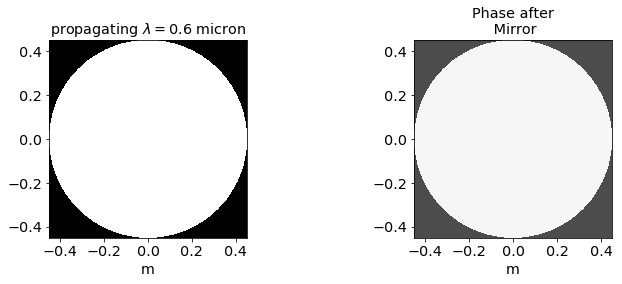

In [28]:
plt.figure(figsize=(12,8))
psf, waves = ctio_grat.calcPSF(wavelength=wavelength_0, display_intermediates=True, return_intermediates=True)